# Inertial Navigation
## Kalman filtering of accelerometer data

In [17]:
import numpy as np
import matplotlib.pyplot as plt

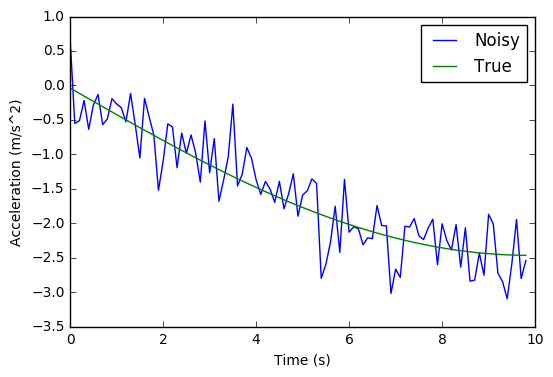

In [126]:
# Number of samples
Tend = 10.
N = 100
h = Tend/N

# Create a time vector
time = np.linspace(0, Tend, N+1)

# Displacement
displacement = 100 * np.sin(np.pi/20*time)
velocity = 1/h * np.diff(displacement)
accel = 1/h * np.diff(velocity)
noise_var = 1e-1
noise = np.sqrt(noise_var) * np.random.randn(N-1)
accel_noisy = accel + noise

plt.plot(time[0:N-1], accel_noisy)
plt.plot(time[0:N-1], accel)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['Noisy', 'True'])
plt.show()

## System state

The state is the quantity we wish to track in the system as well as its derivatives. It is necessary to know how each element in the state is affected by the other elements.

Our state will be position ($s$), velocity ($v$) and acceleration ($a$): $\large x = \begin{bmatrix} s \\ v \\ a \end{bmatrix}$

## State equation

Applying Forward Euler integration to find velocity: $\large v_k = v_{k-1} + ha_{k-1}$

and to find displacement: $\large s_k  = s_{k-1} + hv_{k-1} = s_{k-1} + h(v_{k-1} + ha_{k-1}) = s_{k-1} + hv_{k-1} + h^2 a_{k-1}$

Writing these in matrix form:

$\large \begin{bmatrix} s_k \\ v_k \\ a_k \end{bmatrix} = \begin{bmatrix} 1 & h & h^2 \\ 0 & 1 & h \\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix} s_{k-1} \\ v_{k-1} \\ a_{k-1} \end{bmatrix} \Longleftrightarrow x_k = Fx_{k-1}$

## Measurement equation

We measure the acceleration of the system (with our accelerometer):

$\large y_k = a_k = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix} x_k$

In [127]:
# State transition matrix
F = np.array([[1, h, h**2], [0, 1, h], [0, 0, 1]])
# Measurement (just give accel)
H = np.array([0, 0, 1])

## State (or process) noise

We understand the system to be undergoing changes in acceleration of a magnitude we do not know. So we will let

$\large Q = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}$

## Measurement noise

We know that the measurement noise from the accelerometer is AWGN with variance 0.1:

$\large R = 0.1$

In [150]:
# Process noise
Q = np.zeros([3,3])
Q[2,2] = 1
# Measurement noise
R = 0.1

In [151]:
Nstep = len(time)-2

# Initial state
x = np.array([displacement[0], velocity[0], accel[0]]).T
xstore = np.zeros([3, Nstep])

# Initial covariance
P = np.eye(3)

# Run through time
for i in range(Nstep):
    # Predict
    xp = F.dot(x)
    Pp = F.dot(P).dot(F.T) + Q
    # Update
    y = accel[i] - H.dot(x)
    S = H.dot(P).dot(H.T) + R
    K = Pp.dot(H.T).dot(1/S)
    x = xp + K.dot(y)
    P = (np.eye(3) - K.dot(H)).dot(Pp)
    # Store
    xstore[:,i] = x

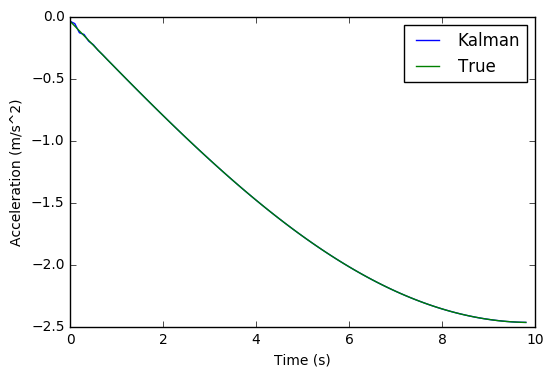

In [152]:
plt.plot(time[0:N-1], xstore[2,:])
plt.plot(time[0:N-1], accel)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['Kalman', 'True'])
plt.show()

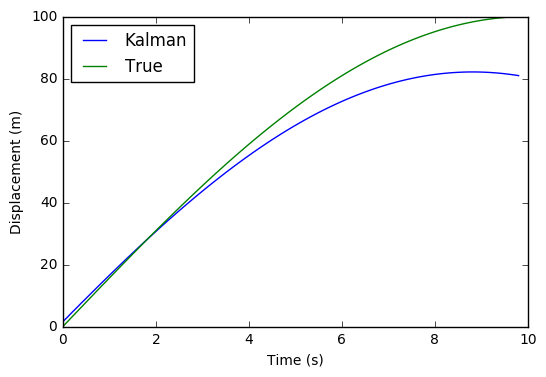

Final error 19m (19%)


In [155]:
plt.plot(time[0:N-1], xstore[0,:])
plt.plot(time[0:N+1], displacement)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend(['Kalman', 'True'], loc=2)
plt.show()
print("Final error %dm (%d%%)" % (abs(xstore[0,-1] - displacement[-1]), \
                                  100*abs(xstore[0,-1]-displacement[-1])/displacement[-1]))